In [1]:
import muon as mu
import mofapy2
import mofax
import pandas as pd
import scanpy as sc
import numpy as np

In [2]:
import os
os.chdir('/icgc/dkfzlsdf/analysis/B260/users/velten/projects/infrastructure/multi-omics-tutorials/')

## Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample.

In [3]:
datadir = "data/evodevo"

In [4]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

/icgc/dkfzlsdf/analysis/B260/software/users/velten/envs/muon/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


First, we create a collection of AnnData objects from this dataframe, one for each organ.

In [5]:
mods = {m:sc.AnnData(data[data.view == m].pivot(index='sample', columns='feature', values='value')) for m in (data['view']).unique()}
mods

{'Brain': AnnData object with n_obs × n_vars = 83 × 7696,
 'Cerebellum': AnnData object with n_obs × n_vars = 83 × 7696,
 'Heart': AnnData object with n_obs × n_vars = 83 × 7696,
 'Liver': AnnData object with n_obs × n_vars = 83 × 7696,
 'Testis': AnnData object with n_obs × n_vars = 83 × 7696}

In addition, we keep the meta data for each sample, containing the developmental time points.

In [23]:
obs = data[['sample', 'time', 'group']].drop_duplicates()
obs.rename(columns = {'group' : 'species'}, inplace = True)
obs = obs.set_index('sample') 
obs

,time,species
sample,,
4wpc_Human,1,Human
5wpc_Human,2,Human
6wpc_Human,3,Human
7wpc_Human,4,Human
8wpc_Human,5,Human
...,...,...
P3_Rat,12,Rat
P7_Rat,13,Rat
P14_Rat,14,Rat


We create a muon object

In [24]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

This contains both the gene expression data,

In [25]:
mdata
mdata['Brain']

AnnData object with n_obs × n_vars = 83 × 7696

as well as the sample-level information given by the developmental time points, which are not yet matched for different species.

In [26]:
mdata.obs # problem: this is sorted by sample name and leads to wrong annotation if these are not order by views

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human


## Integrate data

MEFISTO can be run on a MuData using the mofa command and specifying the time information to use.

We will fill missing samples in certain modalities with NAs by using use_obs='union'.

We specify to use the species as groups.

As we want to incorporate the time information we specify which column in the metadata to use as covariate for mefisto ("time").

In addition, we tell the model that we want to learn an alignment of the time points from different species by setting mefisto_warping to True and using Mouse as reference.

For illustration, we only use a small number of training iterations.

In [10]:
ref_species = np.where(mdata.obs['species'].unique() == "Mouse")[0]
ref_species = ref_species.item()
ref_species

1

In [11]:
mu.tl.mofa(mdata, use_obs='union', 
           groups_label="species",
           n_factors=5, 
           mefisto_covariate = 'time',
           mefisto_warping = True,
           mefisto_warping_ref = ref_species,
           outfile="models/mefisto_evodevo.hdf5",
           n_iterations = 25)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' g

## Visualization in the factor space

Let's take a look at the decomposition learnt by the model.

... storing 'species' as categorical


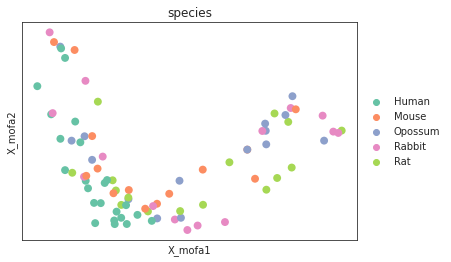

In [12]:
mu.pl.mofa(mdata, color="species", size = 250)

... storing 'species' as categorical


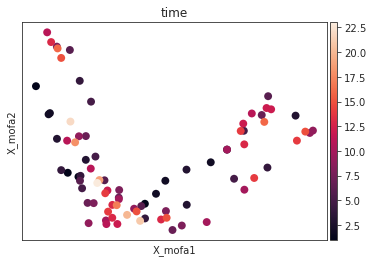

In [13]:
mu.pl.mofa(mdata, color="time", size = 250)

... storing 'species' as categorical


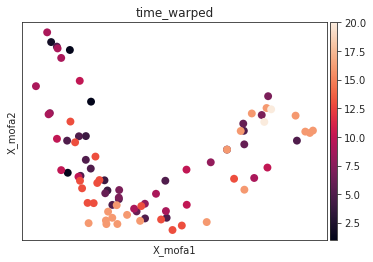

In [14]:
mu.pl.mofa(mdata, color="time_warped", size = 250)

## Latent factors versus common developmental time

We can plot the latent processes along the inferred common developmental time.

In [15]:
mdata.obsm['X_mofa'].shape

(83, 5)

<AxesSubplot:xlabel='time', ylabel='Factor1'>

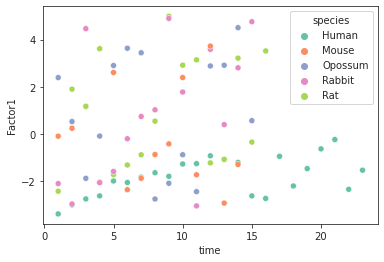

In [16]:
import seaborn as sns
df = pd.DataFrame({'time' : mdata.obs['time'], 'Factor1' : mdata.obsm['X_mofa'][:,0], 'species' : mdata.obs['species']})
sns.scatterplot(x = "time", y = "Factor1", hue = "species", data = df)

## Alignment

We can also take a look at the learnt alignemnt.

<AxesSubplot:xlabel='time', ylabel='time_warped'>

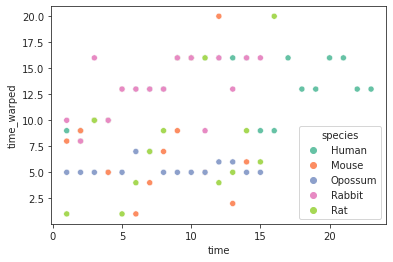

In [17]:
sns.scatterplot(x = "time", y = "time_warped", hue = "species", data = mdata.obs)

## Further analyes

Additionally we can take a look at the smoothness and sharedness of the factors, interpolate the factors or cluster the species based on the learnt group kernel of each latent factor.
This is not yet implemented for muon and can be done from R as described [here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html).